In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import date
import math
import yfinance as yf
from yahoofinancials import YahooFinancials

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [30]:
data = yf.download('TCS.NS', start='2000-01-01', end='2024-06-25', progress=False,
)
print(data.head())
data = data[['Adj Close']]  # Assuming 'Date' is the column containing dates
data.columns = ['Price']
data.head()

                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2002-08-12  38.724998  40.000000  38.724998  39.700001  27.918373  212976
2002-08-13  39.750000  40.387501  38.875000  39.162498  27.540375  153576
2002-08-14  39.250000  39.250000  35.724998  36.462502  25.641647  822776
2002-08-15  36.462502  36.462502  36.462502  36.462502  25.641647       0
2002-08-16  36.275002  38.000000  35.750000  36.375000  25.580109  811856


,Price
Date,
2002-08-12,27.918373
2002-08-13,27.540375
2002-08-14,25.641647
2002-08-15,25.641647
2002-08-16,25.580109


In [31]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 5427 number of days in the dataset.


In [32]:
data.index

DatetimeIndex(['2002-08-12', '2002-08-13', '2002-08-14', '2002-08-15',
               '2002-08-16', '2002-08-19', '2002-08-20', '2002-08-21',
               '2002-08-22', '2002-08-23',
               ...
               '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13',
               '2024-06-14', '2024-06-18', '2024-06-19', '2024-06-20',
               '2024-06-21', '2024-06-24'],
              dtype='datetime64[ns]', name='Date', length=5427, freq=None)

No handles with labels found to put in legend.


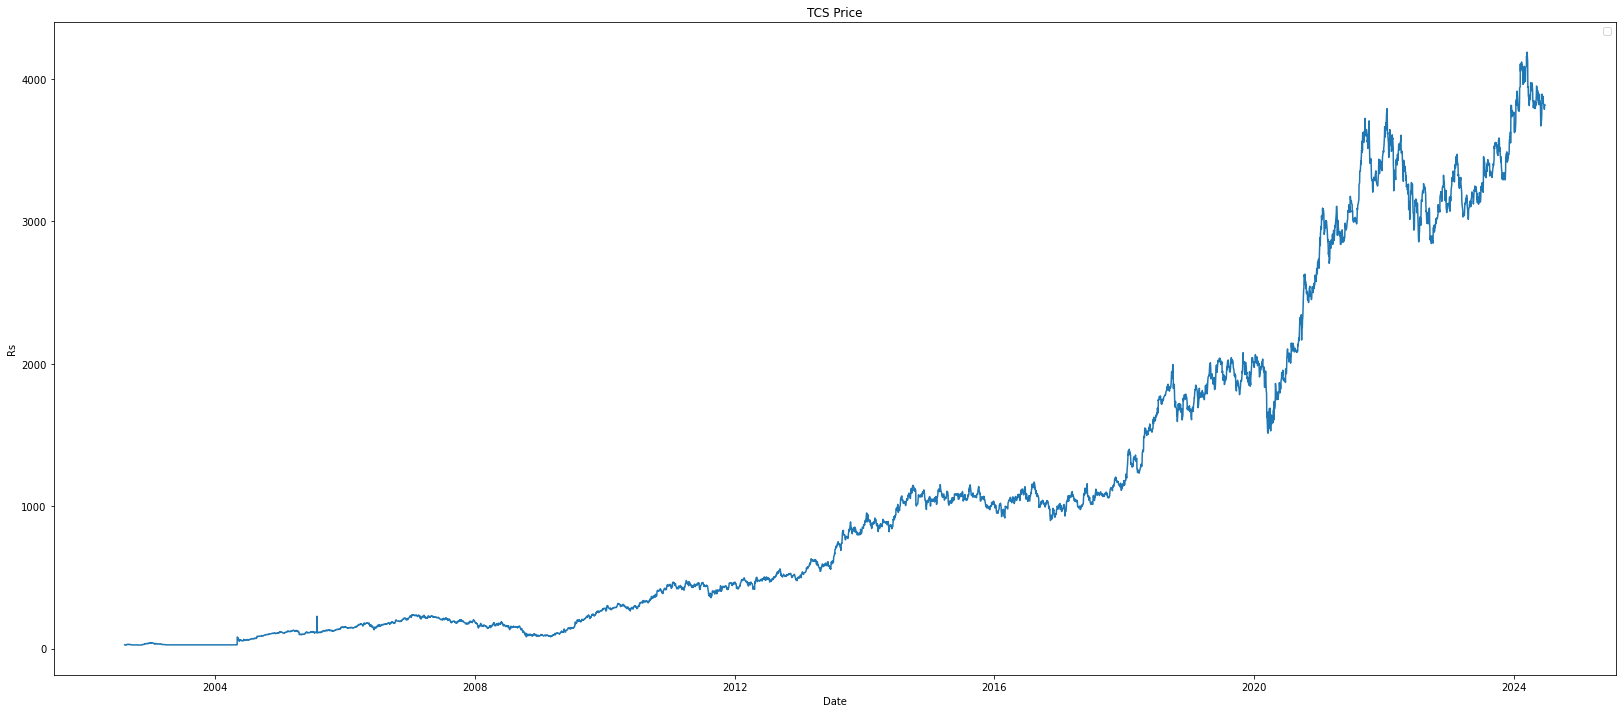

In [34]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data.index.values, data['Price'].values)
plt.xlabel('Date')
plt.ylabel('Rs')
plt.title('TCS Price')
plt.legend()
plt.show()

In [35]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Price'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Price'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Price'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Price']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [36]:
df = get_technical_indicators(data)

<ipython-input-35-c0fc4fb141be>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
<ipython-input-35-c0fc4fb141be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['ma21'] = dataset['Price'].rolling(window=21).mean()
<ipython-input-35-c0fc4fb141be>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [37]:
df = df.dropna()
df.head()

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2002-09-09,28.788609,30.117224,28.325655,28.929936,29.372972,0.443036,1.946428,32.218511,24.432798,29.043111,27.788609,3.324626
2002-09-10,28.788609,29.804533,28.367095,28.917108,29.280733,0.363625,1.946587,32.260269,24.473920,28.873443,27.788609,3.324626
2002-09-11,29.518227,29.550869,28.461278,28.970776,29.318071,0.347295,1.952427,32.366131,24.556425,29.303299,28.518227,3.350543
2002-09-12,29.667660,29.528267,28.652993,29.032061,29.372848,0.340786,1.857049,32.367090,24.938896,29.546206,28.667660,3.355770
2002-09-13,28.823776,29.292181,28.804523,29.013995,29.287058,0.273063,1.724114,32.252751,25.356295,29.064586,27.823776,3.325891


In [38]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot

    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

<Figure size 1600x1000 with 0 Axes>

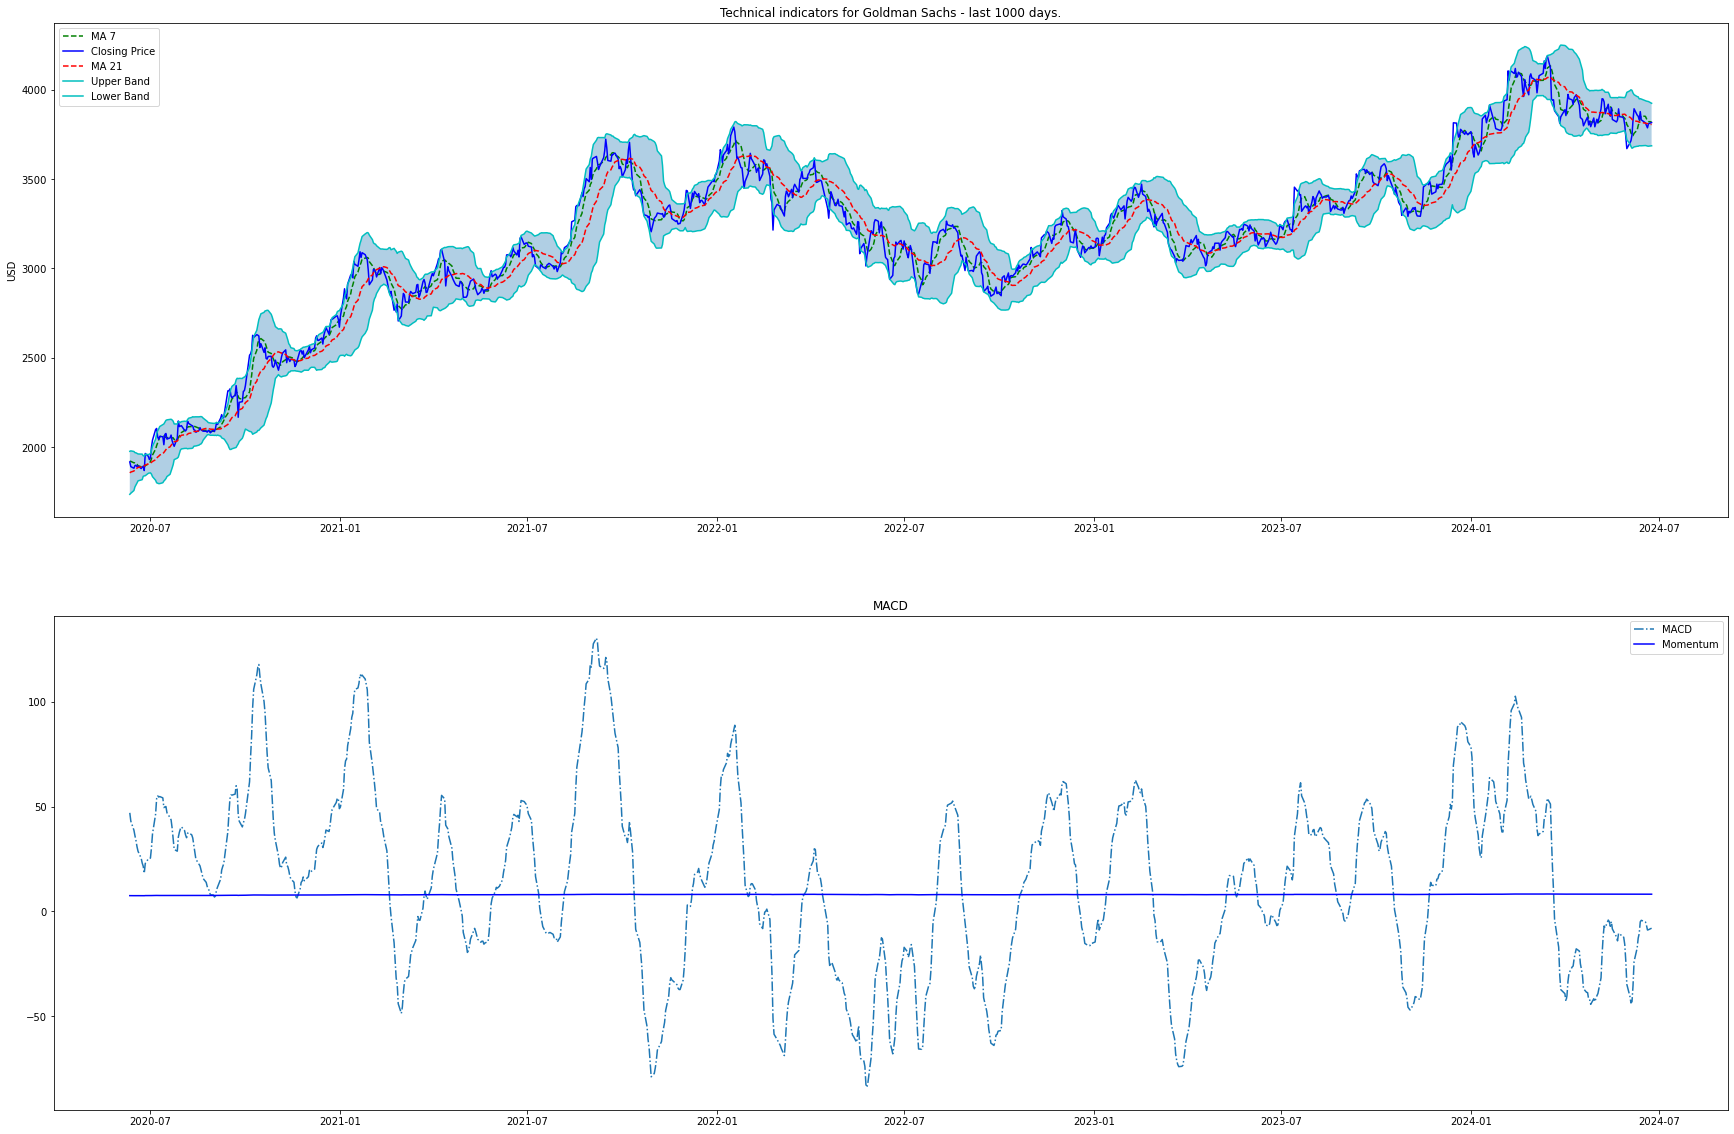

In [39]:
plot_technical_indicators(df, 1000)

Text(0.5, 1.0, 'Params')

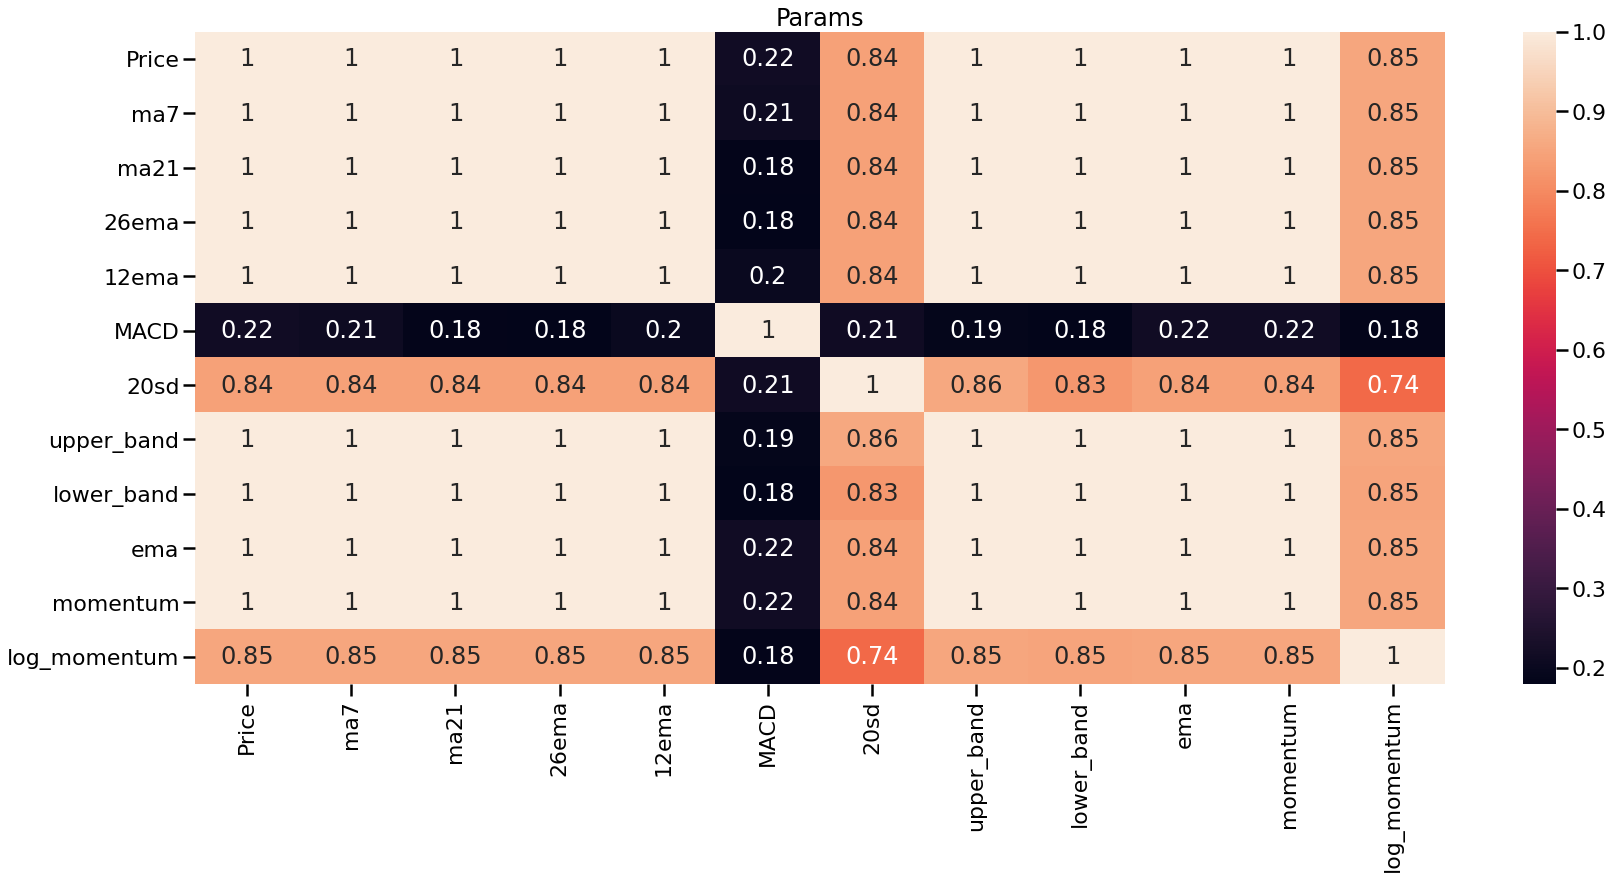

In [40]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(df.corr(), annot = True).set_title('Params')


In [41]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 5407 samples, and 12 features.


In [42]:
df.columns

Index(['Price', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band',
       'lower_band', 'ema', 'momentum', 'log_momentum'],
      dtype='object')

In [43]:
df

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2002-09-09,28.788609,30.117224,28.325655,28.929936,29.372972,0.443036,1.946428,32.218511,24.432798,29.043111,27.788609,3.324626
2002-09-10,28.788609,29.804533,28.367095,28.917108,29.280733,0.363625,1.946587,32.260269,24.473920,28.873443,27.788609,3.324626
2002-09-11,29.518227,29.550869,28.461278,28.970776,29.318071,0.347295,1.952427,32.366131,24.556425,29.303299,28.518227,3.350543
2002-09-12,29.667660,29.528267,28.652993,29.032061,29.372848,0.340786,1.857049,32.367090,24.938896,29.546206,28.667660,3.355770
2002-09-13,28.823776,29.292181,28.804523,29.013995,29.287058,0.273063,1.724114,32.252751,25.356295,29.064586,27.823776,3.325891
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-18,3815.100098,3851.671422,3813.490467,3831.056527,3826.118036,-4.938492,62.577232,3938.644932,3688.336002,3824.434387,3814.100098,8.246460
2024-06-19,3801.699951,3838.492850,3811.947603,3828.881966,3822.361407,-6.520559,62.442962,3936.833527,3687.061678,3809.278096,3800.699951,8.242941
2024-06-20,3787.250000,3828.285714,3810.378557,3825.798117,3816.959652,-8.838464,62.638902,3935.656362,3685.100753,3794.592699,3786.250000,8.239131


In [44]:
data_training = df[df.index < '2019-01-31'].copy()
data_training

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2002-09-09,28.788609,30.117224,28.325655,28.929936,29.372972,0.443036,1.946428,32.218511,24.432798,29.043111,27.788609,3.324626
2002-09-10,28.788609,29.804533,28.367095,28.917108,29.280733,0.363625,1.946587,32.260269,24.473920,28.873443,27.788609,3.324626
2002-09-11,29.518227,29.550869,28.461278,28.970776,29.318071,0.347295,1.952427,32.366131,24.556425,29.303299,28.518227,3.350543
2002-09-12,29.667660,29.528267,28.652993,29.032061,29.372848,0.340786,1.857049,32.367090,24.938896,29.546206,28.667660,3.355770
2002-09-13,28.823776,29.292181,28.804523,29.013995,29.287058,0.273063,1.724114,32.252751,25.356295,29.064586,27.823776,3.325891
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-24,1689.581055,1681.711042,1674.829264,1685.271576,1677.586036,-7.685540,22.127331,1719.083927,1630.574601,1684.563359,1688.581055,7.431644
2019-01-25,1706.684692,1688.647862,1675.503389,1686.857733,1682.062753,-4.794980,22.895800,1721.294988,1629.711789,1699.310915,1705.684692,7.441722
2019-01-28,1737.072510,1696.352679,1678.169195,1690.577346,1690.525792,-0.051554,26.546804,1731.262803,1625.075587,1724.485311,1736.072510,7.459381


In [45]:
data_testing = df[df.index >= '2019-01-31'].copy()
data_testing

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2019-01-31,1789.584595,1730.243687,1689.649513,1707.227681,1722.721656,15.493975,42.832850,1775.315212,1603.983814,1778.653545,1788.584595,7.489180
2019-02-01,1803.667847,1749.835711,1695.321859,1714.371397,1735.174916,20.803519,49.493199,1794.308257,1596.335460,1795.329746,1802.667847,7.497023
2019-02-04,1821.704834,1768.710536,1702.828416,1722.322022,1748.487211,26.165189,56.037495,1814.903407,1590.753425,1812.913138,1820.704834,7.506979
2019-02-05,1816.640625,1784.418527,1709.205066,1729.308585,1758.972352,29.663767,61.032546,1831.270159,1587.139974,1815.398129,1815.640625,7.504194
2019-02-06,1843.518555,1799.625105,1717.045282,1737.768583,1771.979460,34.210877,67.204437,1851.454156,1582.636409,1834.145080,1842.518555,7.518889
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-18,3815.100098,3851.671422,3813.490467,3831.056527,3826.118036,-4.938492,62.577232,3938.644932,3688.336002,3824.434387,3814.100098,8.246460
2024-06-19,3801.699951,3838.492850,3811.947603,3828.881966,3822.361407,-6.520559,62.442962,3936.833527,3687.061678,3809.278096,3800.699951,8.242941
2024-06-20,3787.250000,3828.285714,3810.378557,3825.798117,3816.959652,-8.838464,62.638902,3935.656362,3685.100753,3794.592699,3786.250000,8.239131


In [46]:
scalar = MinMaxScaler()

data_training_scaled = scalar.fit_transform(data_training)
print(data_training_scaled.shape)
data_training_scaled

(4078, 12)


array([[0.0018157 , 0.00226969, 0.001185  , ..., 0.0018603 , 0.0018157 ,
        0.03124231],
       [0.0018157 , 0.00210597, 0.00120748, ..., 0.00177322, 0.0018157 ,
        0.03124231],
       [0.00218599, 0.00197315, 0.00125857, ..., 0.00199384, 0.00218599,
        0.03711735],
       ...,
       [0.86878056, 0.87467916, 0.89610384, ..., 0.8720434 , 0.86878056,
        0.96852864],
       [0.88129414, 0.8801355 , 0.89825543, ..., 0.88478708, 0.88129414,
        0.97172554],
       [0.88068528, 0.8849671 , 0.90015275, ..., 0.88862447, 0.88068528,
        0.97157103]])

In [47]:
X_train = []
y_train = []

In [48]:
for i in range(60, data_training.shape[0]):
    X_train.append(data_training_scaled[i-60: i])
    y_train.append(data_training_scaled[i, 0])

In [49]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((4018, 60, 12), (4018,))

In [50]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 12)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

In [51]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            12600     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [52]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [53]:
regressor.fit(X_train, y_train, epochs=50, batch_size = 64)

Epoch 1/50
63/63 [==============================] - 27s 311ms/step - loss: 0.0615
Epoch 2/50
63/63 [==============================] - 19s 304ms/step - loss: 0.0047
Epoch 3/50
63/63 [==============================] - 21s 328ms/step - loss: 0.0037
Epoch 4/50
63/63 [==============================] - 19s 301ms/step - loss: 0.0036
Epoch 5/50
63/63 [==============================] - 19s 297ms/step - loss: 0.0034
Epoch 6/50
63/63 [==============================] - 19s 304ms/step - loss: 0.0032
Epoch 7/50
63/63 [==============================] - 19s 298ms/step - loss: 0.0033
Epoch 8/50
63/63 [==============================] - 20s 318ms/step - loss: 0.0028
Epoch 9/50
63/63 [==============================] - 23s 367ms/step - loss: 0.0027
Epoch 10/50
63/63 [==============================] - 19s 306ms/step - loss: 0.0026
Epoch 11/50
63/63 [==============================] - 18s 287ms/step - loss: 0.0023
Epoch 12/50
63/63 [==============================] - 22s 345ms/step - loss: 0.0023
Epoch 13/50
6

In [55]:

past_60 = data_training.tail(60)
dt = pd.concat([past_60, data_testing], ignore_index=True)
dt

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,1676.480103,1677.385655,1714.718093,1728.933127,1692.440107,-36.493020,72.512320,1859.742734,1569.693453,1684.808171,1675.480103,7.423855
1,1713.585205,1694.307565,1707.729329,1727.796244,1695.693199,-32.103045,64.392501,1836.514332,1578.944327,1703.992860,1712.585205,7.445759
2,1721.964233,1703.319510,1702.197080,1727.364243,1699.734897,-27.629346,57.219082,1816.635243,1587.758916,1715.973776,1720.964233,7.450640
3,1692.749756,1705.143467,1694.673282,1724.800207,1698.660260,-26.139947,45.996269,1786.665819,1602.680744,1700.491096,1691.749756,7.433519
4,1697.759033,1702.192243,1689.418759,1722.797157,1698.521609,-24.275548,37.997577,1765.413914,1613.423605,1698.669721,1696.759033,7.436475
...,...,...,...,...,...,...,...,...,...,...,...,...
1384,3815.100098,3851.671422,3813.490467,3831.056527,3826.118036,-4.938492,62.577232,3938.644932,3688.336002,3824.434387,3814.100098,8.246460
1385,3801.699951,3838.492850,3811.947603,3828.881966,3822.361407,-6.520559,62.442962,3936.833527,3687.061678,3809.278096,3800.699951,8.242941
1386,3787.250000,3828.285714,3810.378557,3825.798117,3816.959652,-8.838464,62.638902,3935.656362,3685.100753,3794.592699,3786.250000,8.239131
1387,3810.750000,3822.378557,3809.366653,3824.683441,3816.004321,-8.679120,62.443490,3934.253633,3684.479672,3805.364233,3809.750000,8.245319


In [56]:
inputs = scalar.fit_transform(dt)
print(inputs.shape)
inputs

(1389, 12)


array([[0.06116685, 0.04719652, 0.04610501, ..., 0.0627897 , 0.06116685,
        0.10089598],
       [0.07503269, 0.0537585 , 0.04327595, ..., 0.06999823, 0.07503269,
        0.12239443],
       [0.07816386, 0.05725315, 0.04103648, ..., 0.07449998, 0.07816386,
        0.12718469],
       ...,
       [0.84994246, 0.88127276, 0.89443142, ..., 0.85552755, 0.84994246,
        0.90106694],
       [0.8587242 , 0.87898208, 0.8940218 , ..., 0.85957488, 0.8587242 ,
        0.90713978],
       [0.86098505, 0.87815944, 0.89254427, ..., 0.86243951, 0.86098505,
        0.90869717]])

In [57]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((1329, 60, 12), (1329,))

In [58]:
y_pred = regressor.predict(X_test)

In [59]:
y_pred

array([[0.042523  ],
       [0.04204588],
       [0.04169847],
       ...,
       [0.6779387 ],
       [0.67776656],
       [0.67764294]], dtype=float32)

In [60]:
scale = 1/scalar.scale_[0]

In [61]:
y_pred = y_pred*scale
y_test = y_test*scale

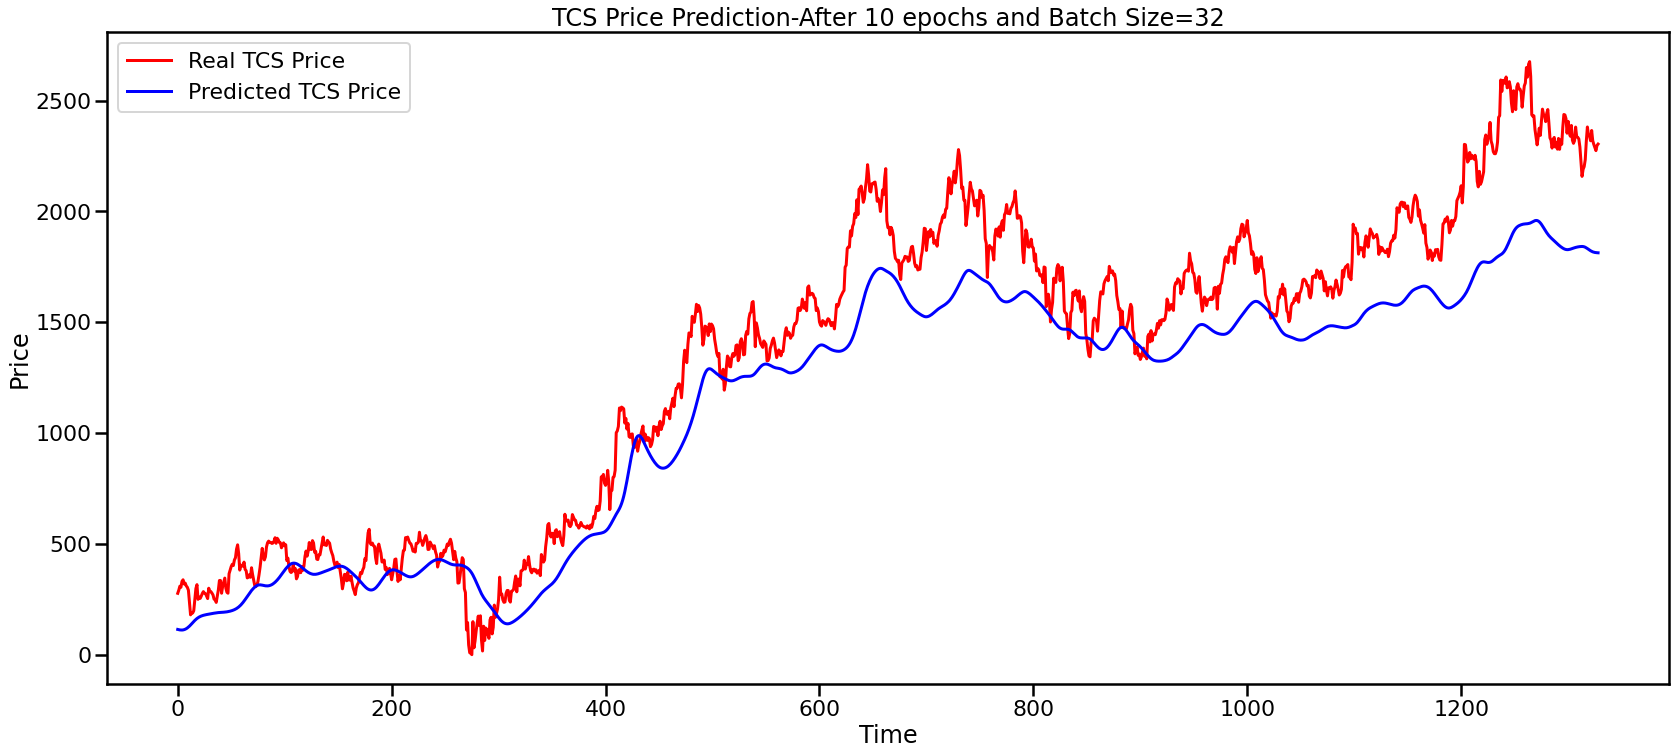

In [62]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real TCS Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted TCS Price')
plt.title('TCS Price Prediction-After 10 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

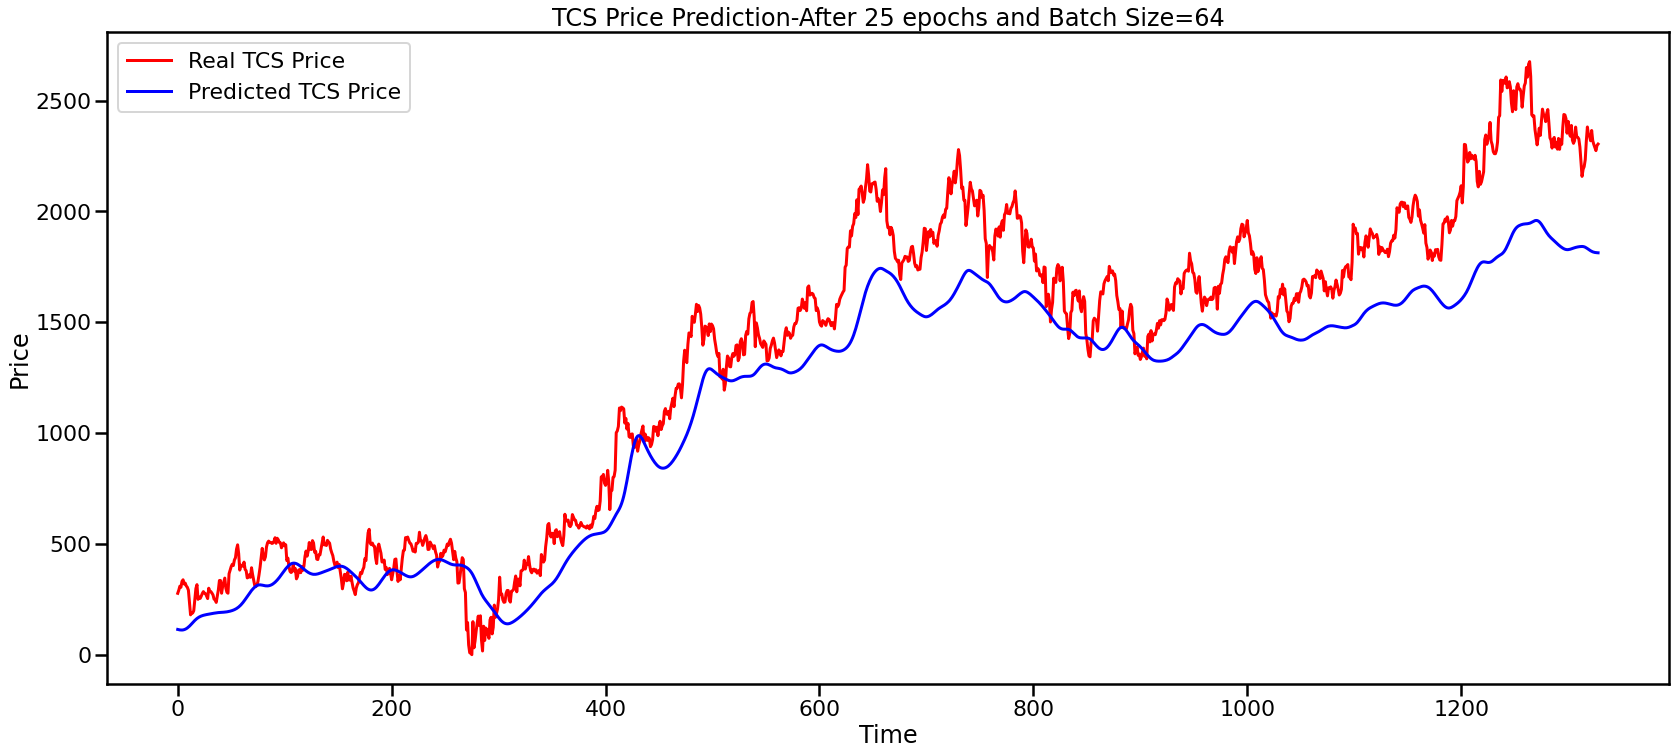

In [63]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real TCS Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted TCS Price')
plt.title('TCS Price Prediction-After 25 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

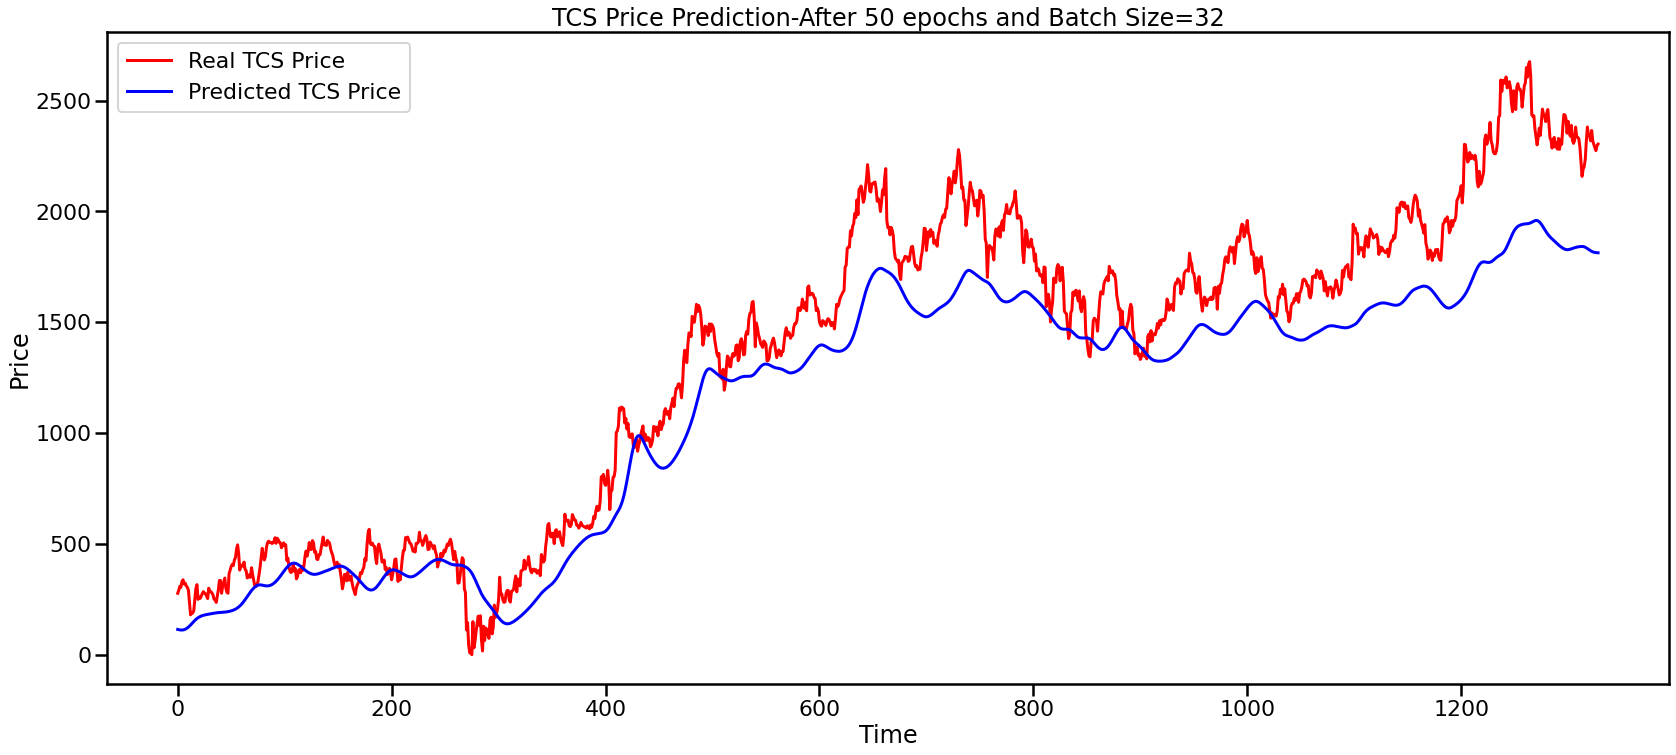

In [64]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real TCS Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted TCS Price')
plt.title('TCS Price Prediction-After 50 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()